# CLIP on BUSI Breast Ultrasound Dataset


In [ ]:
import os
import torch
import clip
import numpy as np
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


## BUSI Dataset Loader

In [ ]:
class BreastUltrasoundDataset(Dataset):

    def __init__(self, image_dir, transform=None, max_samples=None):
        self.image_dir = image_dir
        self.transform = transform
        self.class_names = ["normal", "benign", "malignant"]
        samples = []

        for idx, class_name in enumerate(self.class_names):
            class_folder = os.path.join(image_dir, class_name)
            # Only include original images, skip mask files
            image_files = [
                f for f in os.listdir(class_folder)
                if f.lower().endswith('.png')
                and "_mask" not in f.lower()
            ]
            image_files.sort()  # Consistent order

            for filename in image_files:
                path = os.path.join(class_folder, filename)
                samples.append((path, idx))

        if max_samples is not None:
            samples = samples[:max_samples]

        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

## Data Preparation

In [ ]:
image_root_dir = "./data/Dataset_BUSI_with_GT"
class_names = ["normal", "benign", "malignant"]

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.48145466, 0.4578275, 0.40821073), 
        std=(0.26862954, 0.26130258, 0.27577711)
    )
])

full_dataset = BreastUltrasoundDataset(image_root_dir, transform=preprocess)

generator = torch.Generator().manual_seed(42)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_dataset,
    [train_size, val_size],
    generator=generator
)

batch_size = 4

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=0, 
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=0, 
    pin_memory=True
)

print(f"Train/val split: {len(train_dataset)}/{len(val_dataset)}")

Train/val split: 624/156


## Load CLIP Model

In [5]:
model_name = "ViT-B/32"
clip_model, _ = clip.load(model_name, device=device)
clip_model.eval()
print(f"Loaded CLIP: {model_name}")

Loaded CLIP: ViT-B/32


## Zero-Shot Evaluation

In [13]:
def evaluate_clip_on_dataset(model, dataloader, class_names):
    correct = 0
    total = 0
    prompts = [f'an ultrasound image of {c} breast tissue' for c in class_names]
    text_tokens = clip.tokenize(prompts).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            batch_size = images.shape[0]
            chunk_size = 2
            all_predictions = []
            for i in range(0, batch_size, chunk_size):
                chunk_images = images[i:i+chunk_size]
                chunk_image_features = model.encode_image(chunk_images)
                chunk_image_features /= chunk_image_features.norm(dim=-1, keepdim=True)
                chunk_similarity = chunk_image_features @ text_features.T
                _, chunk_predicted = chunk_similarity.max(1)
                all_predictions.extend(chunk_predicted.tolist())
            predictions = torch.tensor(all_predictions, device=device)
            total += labels.size(0)
            correct += (predictions == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Zero-shot accuracy: {accuracy:.2f}%")
    return accuracy

clip_zeroshot_acc = evaluate_clip_on_dataset(clip_model, val_loader, class_names)

Evaluating: 100%|██████████| 39/39 [00:10<00:00,  3.78it/s]

Zero-shot accuracy: 25.00%


## Fine-Tuning: Linear Layer on CLIP Visual Features

In [ ]:
class CLIPFineTuner:
    """
    Fine-tuning class for CLIP on BUSI dataset (or similar).
    - Freezes CLIP encoder and only trains a classifier head.
    """

    def __init__(self, clip_model, class_count, device, learning_rate=1e-3):
        self.device = device
        # Freeze
        self.clip_model = clip_model.eval().to(device)
        for param in self.clip_model.parameters():
            param.requires_grad = False
        feature_dim = clip_model.visual.output_dim
        self.classifier = nn.Linear(feature_dim, class_count).to(device)
        self.optimizer = optim.Adam(self.classifier.parameters(), lr=learning_rate)
        self.loss_fn = nn.CrossEntropyLoss()

    def train_step(self, images, labels):
        self.optimizer.zero_grad()

        with torch.no_grad():
            image_features = self.clip_model.encode_image(images)

        logits = self.classifier(image_features)
        loss = self.loss_fn(logits, labels)
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def train_epoch(self, dataloader):
        self.clip_model.eval()                  
        self.classifier.train()
        total_loss, correct, total_samples, batch_count = 0, 0, 0, 0

        for images, labels in tqdm(dataloader, desc="Training"):
            images = images.to(self.device)
            labels = labels.to(self.device)

            loss = self.train_step(images, labels)
            total_loss += loss

            with torch.no_grad():
                image_features = self.clip_model.encode_image(images)
                logits = self.classifier(image_features)
                predictions = logits.argmax(dim=1)
                correct += (predictions == labels).sum().item()
                total_samples += labels.size(0)
            batch_count += 1

        avg_loss = total_loss / batch_count if batch_count > 0 else 0
        train_acc = 100.0 * correct / total_samples if total_samples > 0 else 0

        return avg_loss, train_acc

    def evaluate(self, dataloader):
        self.clip_model.eval()
        self.classifier.eval()

        correct, total, val_loss, batch_count = 0, 0, 0, 0

        with torch.no_grad():
            for images, labels in tqdm(dataloader, desc="Evaluating"):
                images = images.to(self.device)
                labels = labels.to(self.device)
                image_features = self.clip_model.encode_image(images)
                logits = self.classifier(image_features)
                predictions = logits.argmax(dim=1)
                correct += (predictions == labels).sum().item()
                total += labels.size(0)
                val_loss += self.loss_fn(logits, labels).item()
                batch_count += 1

        accuracy = 100.0 * correct / total if total > 0 else 0
        avg_loss = val_loss / batch_count if batch_count > 0 else 0

        print(f"Validation accuracy: {accuracy:.2f}%, avg loss: {avg_loss:.4f}")
        return accuracy, avg_loss

In [9]:
def save_model(model, optimizer, epoch, path="saved_models/fine_tuned_clip_busi.pt"):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.classifier.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, path)
    print(f"Model saved at epoch {epoch + 1} to: {path}")

def load_fine_tuned_model(model, optimizer=None, path="saved_models/fine_tuned_clip_busi.pt", device='cpu'):
    if not os.path.exists(path):
        print(f"No saved model found at: {path}. Ensure the path is correct.")
        return None, None, None

    checkpoint = torch.load(path, map_location=device)
    model.classifier.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint.get('epoch', None)

    if optimizer is not None and 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f"Successfully loaded fine-tuned model and optimizer from: {path}")
    else:
        print(f"Successfully loaded fine-tuned model from: {path}")

    return model, optimizer, epoch

## Run Training & Evaluation

In [23]:
import numpy as np

num_epochs = 3
tuner = CLIPFineTuner(clip_model, len(class_names), device)

# For tracking per-layer gradients
layer_names = [name for name, _ in tuner.classifier.named_parameters()]
num_layers = len(layer_names)
layerwise_grads = np.zeros((num_layers, num_epochs))

# For tracking overall loss/accuracy
losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Train for one epoch
    train_loss, train_acc = tuner.train_epoch(train_loader)
    print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.2f}%")

    # Collect gradients after training epoch
    epoch_grads = []
    for idx, (name, param) in enumerate(tuner.classifier.named_parameters()):
        grad_value = param.grad
        if grad_value is not None:
            mean_grad = grad_value.abs().mean().cpu().item()
        else:
            mean_grad = 0.0
        layerwise_grads[idx, epoch] = mean_grad
        epoch_grads.append(mean_grad)
    print("  Layerwise mean gradients:", {name: f"{val:.4e}" for name, val in zip(layer_names, epoch_grads)})

    # Validate after one epoch
    val_acc, val_loss = tuner.evaluate(val_loader)
    print(f"Val acc: {val_acc:.2f}% | Val loss: {val_loss:.4f}")

    # Store metrics for later plotting/analysis
    losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

# After training loop is done:
save_model(tuner, tuner.optimizer, num_epochs - 1, path="saved_models/fine_tuned_clip_busi.pt")
print("\nCollected layerwise gradients matrix (shape {}):".format(layerwise_grads.shape))
print("  Rows: ", layer_names)
print("  Columns: epochs (per column)")
print(layerwise_grads)


Epoch 1/3


Training: 100%|██████████| 156/156 [01:04<00:00,  2.42it/s]


Train loss: 0.8707 | Train acc: 61.06%
  Layerwise mean gradients: {'weight': '2.1101e-02', 'bias': '5.1758e-02'}


Evaluating: 100%|██████████| 39/39 [00:08<00:00,  4.39it/s]


Validation accuracy: 50.00%, avg loss: 0.9119
Val acc: 50.00% | Val loss: 0.9119

Epoch 2/3


Training: 100%|██████████| 156/156 [01:05<00:00,  2.38it/s]


Train loss: 0.7424 | Train acc: 67.63%
  Layerwise mean gradients: {'weight': '5.6116e-02', 'bias': '2.0078e-01'}


Evaluating: 100%|██████████| 39/39 [00:09<00:00,  4.32it/s]


Validation accuracy: 66.03%, avg loss: 0.7515
Val acc: 66.03% | Val loss: 0.7515

Epoch 3/3


Training: 100%|██████████| 156/156 [01:05<00:00,  2.38it/s]


Train loss: 0.6661 | Train acc: 73.72%
  Layerwise mean gradients: {'weight': '4.8978e-02', 'bias': '1.7882e-01'}


Evaluating: 100%|██████████| 39/39 [00:09<00:00,  4.30it/s]

Validation accuracy: 71.79%, avg loss: 0.7047
Val acc: 71.79% | Val loss: 0.7047
Model saved at epoch 3 to: saved_models/fine_tuned_clip_busi.pt

Collected layerwise gradients matrix (shape (2, 3)):
  Rows:  ['weight', 'bias']
  Columns: epochs (per column)
[[0.02110091 0.05611638 0.0489777 ]
 [0.05175827 0.20078194 0.17881726]]


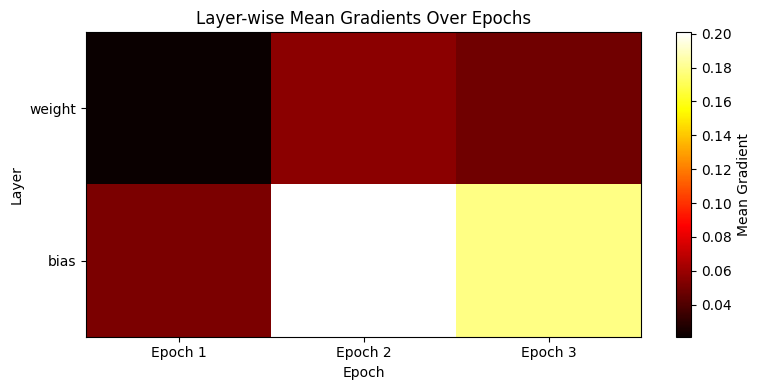

In [24]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(8, 4))
im = plt.imshow(layerwise_grads, aspect='auto', cmap='hot')
plt.colorbar(im, label='Mean Gradient')
plt.xticks(range(num_epochs), [f'Epoch {i+1}' for i in range(num_epochs)])
plt.yticks(range(num_layers), layer_names)
plt.xlabel('Epoch')
plt.ylabel('Layer')
plt.title('Layer-wise Mean Gradients Over Epochs')
plt.tight_layout()
plt.show()

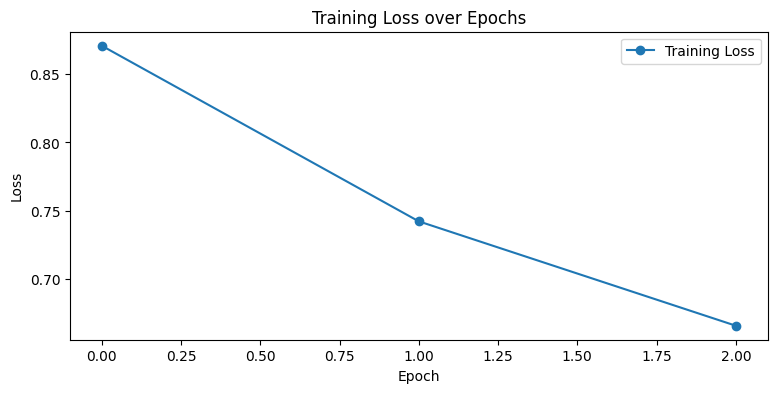

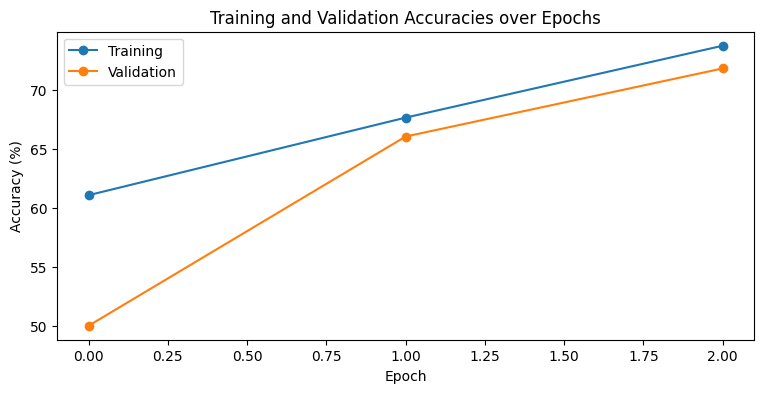

In [25]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.title('Training Loss over Epochs')
plt.plot(losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.gcf().set_size_inches(9, 4)
plt.legend(loc='upper right')
plt.show()
plt.figure()
plt.title('Training and Validation Accuracies over Epochs')
plt.plot(train_accuracies, '-o', label='Training Accuracy')
plt.plot(val_accuracies, '-o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.gcf().set_size_inches(9, 4)
plt.show()